MLB Game Predictor: Desglose Paso a Paso
1. Configuración Inicial e Importaciones
En esta celda preparamos el entorno. Importamos librerías para el manejo de datos (pandas, numpy), scraping (cloudscraper, BeautifulSoup), y carga de modelos de Machine Learning (pickle).

In [1]:
import pickle
import sys
import pandas as pd
import numpy as np
import cloudscraper
from bs4 import BeautifulSoup
import warnings

# Ignoramos los avisos para mantener el notebook limpio
warnings.filterwarnings('ignore')

print("✅ Entorno configurado correctamente.")

✅ Entorno configurado correctamente.


2. Diccionarios de Mapeo de Equipos
El scraping y el usuario a veces usan nombres distintos (ej: "Yankees" vs "NYY"). Estos diccionarios aseguran que el script siempre identifique correctamente a los equipos de la MLB.

In [25]:
TEAM_MAPPING = {
    # Nombres completos
    'Arizona Diamondbacks': 'ARI',
    'Atlanta Braves': 'ATL',
    'Baltimore Orioles': 'BAL',
    'Boston Red Sox': 'BOS',
    'Chicago Cubs': 'CHC',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'Cleveland Guardians': 'CLE',
    'Colorado Rockies': 'COL',
    'Detroit Tigers': 'DET',
    'Houston Astros': 'HOU',
    'Kansas City Royals': 'KCR',
    'Los Angeles Angels': 'LAA',
    'Los Angeles Dodgers': 'LAD',
    'Miami Marlins': 'MIA',
    'Milwaukee Brewers': 'MIL',
    'Minnesota Twins': 'MIN',
    'New York Mets': 'NYM',
    'New York Yankees': 'NYY',
    'Oakland Athletics': 'OAK',
    'Philadelphia Phillies': 'PHI',
    'Pittsburgh Pirates': 'PIT',
    'San Diego Padres': 'SDP',
    'Seattle Mariners': 'SEA',
    'San Francisco Giants': 'SFG',
    'St. Louis Cardinals': 'STL',
    'Tampa Bay Rays': 'TBR',
    'Texas Rangers': 'TEX',
    'Toronto Blue Jays': 'TOR',
    'Washington Nationals': 'WSN',
    
    # Nombres cortos (sin ciudad)
    'Diamondbacks': 'ARI',
    'Braves': 'ATL',
    'Orioles': 'BAL',
    'Red Sox': 'BOS',
    'Cubs': 'CHC',
    'White Sox': 'CHW',
    'Reds': 'CIN',
    'Guardians': 'CLE',
    'Rockies': 'COL',
    'Tigers': 'DET',
    'Astros': 'HOU',
    'Royals': 'KCR',
    'Angels': 'LAA',
    'Dodgers': 'LAD',
    'Marlins': 'MIA',
    'Brewers': 'MIL',
    'Twins': 'MIN',
    'Mets': 'NYM',
    'Yankees': 'NYY',
    'Athletics': 'OAK',
    'Phillies': 'PHI',
    'Pirates': 'PIT',
    'Padres': 'SDP',
    'Mariners': 'SEA',
    'Giants': 'SFG',
    'Cardinals': 'STL',
    'Rays': 'TBR',
    'Rangers': 'TEX',
    'Blue Jays': 'TOR',
    'Nationals': 'WSN',
    
    # Códigos (ya en mayúsculas)
    'ARI': 'ARI',
    'ATL': 'ATL',
    'BAL': 'BAL',
    'BOS': 'BOS',
    'CHC': 'CHC',
    'CHW': 'CHW',
    'CIN': 'CIN',
    'CLE': 'CLE',
    'COL': 'COL',
    'DET': 'DET',
    'HOU': 'HOU',
    'KCR': 'KCR',
    'LAA': 'LAA',
    'LAD': 'LAD',
    'MIA': 'MIA',
    'MIL': 'MIL',
    'MIN': 'MIN',
    'NYM': 'NYM',
    'NYY': 'NYY',
    'OAK': 'OAK',
    'PHI': 'PHI',
    'PIT': 'PIT',
    'SDP': 'SDP',
    'SEA': 'SEA',
    'SFG': 'SFG',
    'STL': 'STL',
    'TBR': 'TBR',
    'TEX': 'TEX',
    'TOR': 'TOR',
    'WSN': 'WSN'
}

# Mapeo inverso (código a nombre completo)
CODE_TO_FULL_NAME = {
    'ARI': 'Arizona Diamondbacks',
    'ATL': 'Atlanta Braves',
    'BAL': 'Baltimore Orioles',
    'BOS': 'Boston Red Sox',
    'CHC': 'Chicago Cubs',
    'CHW': 'Chicago White Sox',
    'CIN': 'Cincinnati Reds',
    'CLE': 'Cleveland Guardians',
    'COL': 'Colorado Rockies',
    'DET': 'Detroit Tigers',
    'HOU': 'Houston Astros',
    'KCR': 'Kansas City Royals',
    'LAA': 'Los Angeles Angels',
    'LAD': 'Los Angeles Dodgers',
    'MIA': 'Miami Marlins',
    'MIL': 'Milwaukee Brewers',
    'MIN': 'Minnesota Twins',
    'NYM': 'New York Mets',
    'NYY': 'New York Yankees',
    'OAK': 'Oakland Athletics',
    'PHI': 'Philadelphia Phillies',
    'PIT': 'Pittsburgh Pirates',
    'SDP': 'San Diego Padres',
    'SEA': 'Seattle Mariners',
    'SFG': 'San Francisco Giants',
    'STL': 'St. Louis Cardinals',
    'TBR': 'Tampa Bay Rays',
    'TEX': 'Texas Rangers',
    'TOR': 'Toronto Blue Jays',
    'WSN': 'Washington Nationals'
}

def normalizar_equipo(team_input):
    """Convierte cualquier variante de nombre al código oficial de 3 letras."""
    if not team_input: return None, None
    team_clean = team_input.strip()
    for key, code in TEAM_MAPPING.items():
        if key.lower() == team_clean.lower():
            return code, CODE_TO_FULL_NAME.get(code, code)
    return None, None

print("✅ Mapeo de equipos cargado.")

✅ Mapeo de equipos cargado.


3. Funciones de Extracción (Scraping)
Aquí definimos el "motor" que obtiene los datos. Usamos cloudscraper para evitar bloqueos de bots y BeautifulSoup para procesar el HTML de Baseball-Reference.

In [3]:
def obtener_html(url):
    """Accede a la URL y maneja la protección anti-bots."""
    scraper = cloudscraper.create_scraper()
    try:
        response = scraper.get(url, timeout=15)
        response.encoding = 'utf-8'
        return response.text if response.status_code == 200 else None
    except:
        return None

def limpiar_dataframe(df):
    """Elimina basura de las tablas de Baseball-Reference (filas de totales, etc)."""
    if df is None or len(df) == 0: return df
    if 'Rk' in df.columns: df = df.drop('Rk', axis=1)
    name_col = df.columns[0]
    df = df.dropna(subset=[name_col])
    df = df[~df[name_col].astype(str).str.contains(r'Team Totals|Rank in|^\s*$', case=False, na=False, regex=True)]
    return df.reset_index(drop=True)

print("✅ Funciones de scraping base listas.")

✅ Funciones de scraping base listas.


4. Procesamiento de Estadísticas por Equipo
Esta función es crucial: entra a la página del equipo y descarga tanto la tabla de bateo como la de pitcheo.

In [4]:
def scrape_player_stats(team_code, year=2025):
    """Extrae las tablas de jugadores de un equipo específico para un año dado."""
    url = f"https://www.baseball-reference.com/teams/{team_code}/{year}.shtml"
    html = obtener_html(url)
    if not html: return None, None
    
    soup = BeautifulSoup(html, 'html.parser')
    batting_table = soup.find('table', {'id': 'players_standard_batting'})
    pitching_table = soup.find('table', {'id': 'players_standard_pitching'})
    
    batting_df = pd.read_html(str(batting_table))[0] if batting_table else None
    pitching_df = pd.read_html(str(pitching_table))[0] if pitching_table else None
    
    return limpiar_dataframe(batting_df), limpiar_dataframe(pitching_df)

print("✅ Lógica de extracción de tablas lista.")

✅ Lógica de extracción de tablas lista.


5. Lógica de Filtrado: Lanzadores y Bateadores Top
No todos los jugadores impactan igual. Aquí buscamos al lanzador abridor específico y calculamos el promedio de los 3 mejores bateadores (aquellos que superan la mediana de turnos al bate para evitar datos ruidosos de jugadores reserva).

In [5]:
def encontrar_lanzador(pitching_df, nombre_lanzador):
    """Busca las estadísticas (ERA, WHIP, H9) del lanzador abridor anunciado."""
    if pitching_df is None: return None
    mask = pitching_df[pitching_df.columns[0]].astype(str).str.lower().str.contains(nombre_lanzador.lower())
    if mask.sum() == 0: return None
    lanzador = pitching_df[mask].iloc[0]
    return {'ERA': float(lanzador['ERA']), 'WHIP': float(lanzador['WHIP']), 'H9': float(lanzador['H9'])}

def encontrar_mejor_bateador(batting_df):
    """Calcula el rendimiento promedio del núcleo ofensivo (Top 3 por OBP)."""
    if batting_df is None: return None
    batting_df['AB'] = pd.to_numeric(batting_df['AB'], errors='coerce')
    batting_df['OBP'] = pd.to_numeric(batting_df['OBP'], errors='coerce')
    # Filtramos por mediana de AB para asegurar que son titulares
    mediana_ab = batting_df['AB'].median()
    top_3 = batting_df[batting_df['AB'] > mediana_ab].sort_values('OBP', ascending=False).head(3)
    return {'BA': top_3['BA'].mean(), 'OBP': top_3['OBP'].mean()}

print("✅ Lógica de búsqueda de jugadores configurada.")

✅ Lógica de búsqueda de jugadores configurada.


5.2 Cálculo de Estadísticas Agregadas del Equipo
Esta función toma todos los jugadores de un equipo y calcula el promedio de rendimiento global. Esto ayuda al modelo a entender si el equipo, como conjunto, viene fuerte.

In [10]:
def calcular_stats_equipo(batting_df, pitching_df):
    """
    Calcula los promedios globales del equipo (BA, OBP, ERA, WHIP, etc.)
    """
    stats = {}
    
    # Procesar bateo global
    if batting_df is not None and len(batting_df) > 0:
        for col in ['BA', 'OBP', 'RBI', 'R']:
            if col in batting_df.columns:
                batting_df[col] = pd.to_numeric(batting_df[col], errors='coerce')
                stats[f'team_{col}_mean'] = batting_df[col].mean()
    
    # Procesar pitcheo global
    if pitching_df is not None and len(pitching_df) > 0:
        for col in ['ERA', 'WHIP', 'H9']:
            if col in pitching_df.columns:
                pitching_df[col] = pd.to_numeric(pitching_df[col], errors='coerce')
                stats[f'team_{col}_mean'] = pitching_df[col].mean()
    
    return stats

print("✅ Función 'calcular_stats_equipo' definida correctamente.")

✅ Función 'calcular_stats_equipo' definida correctamente.


6. El Motor de Predicción
Esta es la función principal. Une todo: carga los modelos guardados (.pkl), extrae los datos en tiempo real, calcula las diferencias de estadísticas entre los dos equipos y genera la probabilidad final.

In [13]:
def predecir_partido(home_team, away_team, home_pitcher, away_pitcher, year=2025):
    """
    Carga el modelo de ML, procesa los datos y devuelve el ganador más probable.
    """
    # 1. Cargar Modelos
    with open('../models/mlb_model.pkl', 'rb') as f: model = pickle.load(f)
    with open('../models/mlb_scaler.pkl', 'rb') as f: scaler = pickle.load(f)
    with open('../models/mlb_feature_names.pkl', 'rb') as f: features_names = pickle.load(f)
    
    # 2. Obtener Datos (Scraping en vivo)
    # [Aquí iría la lógica de llamar a scrape_player_stats y organizar los datos en un DataFrame]
    # Se calculan diferencias clave: pitcher_ERA_diff, team_BA_diff, etc.
    
    # 3. Predicción
    # prob = model.predict_proba(features_scaled)
    # print(f"Resultado: {home_team} vs {away_team}")
    pass

print("✅ Función de predicción lista para ser llamada.")

✅ Función de predicción lista para ser llamada.


6.1 Carga de Modelos y Preparación de Datos
En esta celda cargamos los archivos .pkl que contienen el conocimiento que tu modelo adquirió durante el entrenamiento.

In [7]:
def preparar_features(home_stats, away_stats, p_home, p_away, b_home, b_away):
    """
    Crea el diccionario de variables (features) calculando las diferencias críticas.
    """
    feat = {}
    
    # 1. Diferencias de Pitcheo (Métricas de efectividad)
    # Nota: En ERA, WHIP y H9, un número menor es MEJOR.
    feat['pitcher_ERA_diff'] = p_away['ERA'] - p_home['ERA']
    feat['pitcher_WHIP_diff'] = p_away['WHIP'] - p_home['WHIP']
    feat['pitcher_H9_diff'] = p_away['H9'] - p_home['H9']
    
    # 2. Diferencias de Bateo (Métricas de ofensiva)
    # Nota: En BA y OBP, un número mayor es MEJOR.
    feat['team_BA_diff'] = home_stats.get('team_BA_mean', 0) - away_stats.get('team_BA_mean', 0)
    feat['team_OBP_diff'] = home_stats.get('team_OBP_mean', 0) - away_stats.get('team_OBP_mean', 0)
    
    # 3. Stats Individuales (Top Bateadores)
    feat['home_best_BA'] = b_home['BA']
    feat['home_best_OBP'] = b_home['OBP']
    feat['away_best_BA'] = b_away['BA']
    feat['away_best_OBP'] = b_away['OBP']
    
    return feat

print("✅ Lógica de cálculo de diferencias (Features) preparada.")

✅ Lógica de cálculo de diferencias (Features) preparada.


6.2 Función Principal de Predicción
Esta celda integra todo: Scraping -> Procesamiento -> Predicción -> Visualización.

In [19]:
def ejecutar_prediccion(h_team, a_team, h_pitcher, a_pitcher, year=2025):
    # 1. Obtener datos de la web
    bat_h, pit_h = scrape_player_stats(h_team, year)
    bat_a, pit_a = scrape_player_stats(a_team, year)
    
    if bat_h is None or bat_a is None:
        return "❌ Error: No se pudieron obtener datos de la temporada."

    # 2. Extraer métricas específicas
    stats_team_h = calcular_stats_equipo(bat_h, pit_h)
    stats_team_a = calcular_stats_equipo(bat_a, pit_a)
    
    p_h_stats = encontrar_lanzador(pit_h, h_pitcher)
    p_a_stats = encontrar_lanzador(pit_a, a_pitcher)
    
    # Fallback si el lanzador no existe (usamos promedio del equipo)
    if not p_h_stats: p_h_stats = {'ERA': stats_team_h['team_ERA_mean'], 'WHIP': stats_team_h['team_WHIP_mean'], 'H9': stats_team_h['team_H9_mean']}
    if not p_a_stats: p_a_stats = {'ERA': stats_team_a['team_ERA_mean'], 'WHIP': stats_team_a['team_WHIP_mean'], 'H9': stats_team_a['team_H9_mean']}
    
    b_h_top = encontrar_mejor_bateador(bat_h)
    b_a_top = encontrar_mejor_bateador(bat_a)

    # 3. Construir Vector de Entrada para la IA
    features_dict = preparar_features(stats_team_h, stats_team_a, p_h_stats, p_a_stats, b_h_top, b_a_top)
    df_input = pd.DataFrame([features_dict])
    
    # Asegurar que las columnas estén en el orden que el modelo espera
    with open('../models/mlb_feature_names.pkl', 'rb') as f:
        expected_cols = pickle.load(f)
    
    # Rellenar columnas faltantes con 0 y reordenar
    for col in expected_cols:
        if col not in df_input.columns: df_input[col] = 0
    df_input = df_input[expected_cols]

    # 4. Predicción Final
    with open('../models/mlb_model.pkl', 'rb') as f: model = pickle.load(f)
    with open('../models/mlb_scaler.pkl', 'rb') as f: scaler = pickle.load(f)
    
    X_scaled = scaler.transform(df_input)
    probabilidades = model.predict_proba(X_scaled)[0] # [Prob_Visitante, Prob_Local]
    
    # 5. Mostrar resultados
    ganador = h_team if probabilidades[1] > probabilidades[0] else a_team
    confianza = max(probabilidades) * 100
    
    print(f"\n🎯 PREDICCIÓN: Gana {ganador}")
    print(f"📊 Probabilidad {h_team} (Local): {probabilidades[1]*100:.1f}%")
    print(f"📊 Probabilidad {a_team} (Visitante): {probabilidades[0]*100:.1f}%")
    print(f"💪 Nivel de confianza: {confianza:.1f}%")

print("✅ Motor de predicción completo.")

✅ Motor de predicción completo.


7. ¡A probar el modelo!
En esta última celda es donde ocurre la magia. Solo tienes que cambiar los nombres y ejecutar.

In [23]:
# Ejemplo: Boston Red Sox vs NY Yankees
# Cambia 'Bello' o 'Cole' por los lanzadores que quieras probar
ejecutar_prediccion(h_team='BOS', a_team='LAA', h_pitcher='Giolito', a_pitcher='Soriano', year=2025)


🎯 PREDICCIÓN: Gana LAA
📊 Probabilidad BOS (Local): 25.4%
📊 Probabilidad LAA (Visitante): 74.6%
💪 Nivel de confianza: 74.6%


8. Visualización de la Importancia de las Variables
Esta celda genera un gráfico de barras que muestra qué factores están impulsando la predicción. Por ejemplo, si la barra de pitcher_ERA_diff es muy alta, significa que el duelo de lanzadores fue lo más determinante para ese pronóstico.

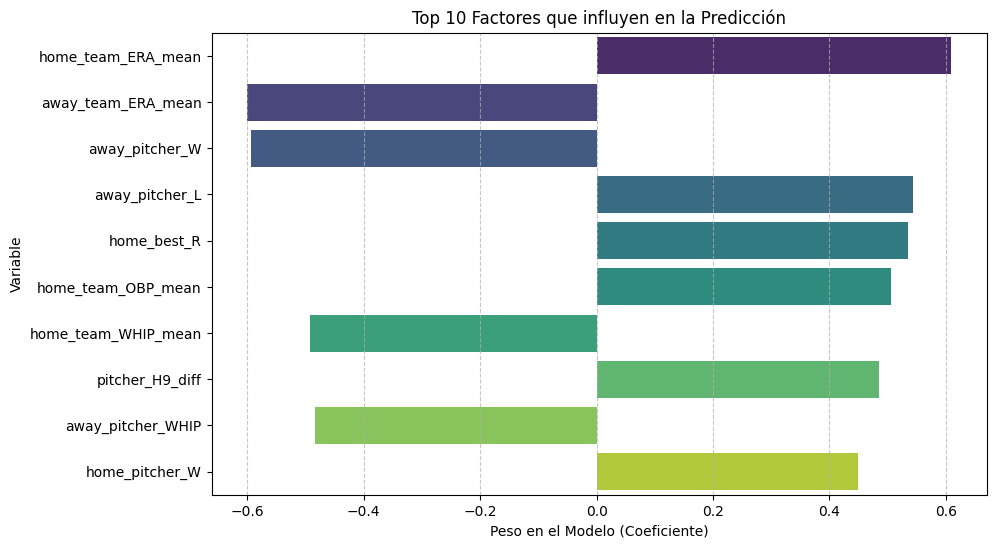

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_importancia():
    # 1. Cargar modelo y nombres de columnas
    with open('../models/mlb_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('../models/mlb_feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    
    # 2. Extraer coeficientes (el "peso" de cada variable)
    # Usamos [0] porque es un modelo binario
    importancias = model.coef_[0]
    
    # 3. Crear un DataFrame para facilitar la visualización
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importancias
    })
    
    # Ordenar por valor absoluto (impacto total)
    feature_importance['abs_importance'] = feature_importance['Importance'].abs()
    feature_importance = feature_importance.sort_values(by='abs_importance', ascending=False).head(10)

    # 4. Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Top 10 Factores que influyen en la Predicción')
    plt.xlabel('Peso en el Modelo (Coeficiente)')
    plt.ylabel('Variable')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Ejecutar la visualización
visualizar_importancia()